In [48]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction.pipeline import load as pipeline
from reproduction.analysis import AEData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Model 

In [4]:
model_dir = "../output/mod09cnn13/"

In [5]:
with open(model_dir + "ae.json", "r") as f:
    ae = tf.keras.models.model_from_json(f.read())
ae.load_weights(model_dir + "ae.h5")
ae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ae_input (InputLayer)           (None, 128, 128, 7)  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 128, 32) 2048        ae_input[0][0]                   
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 32)   9248        conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 32)   9248        conv2d_14[0][0]                  
__________________________________________________________________________________________________
lambda_8 (

In [45]:
dataset = pipeline.load_data(
    data_glob="../data/tif/*.tfrecord",
    shape=(128, 128, 7),
    batch_size=1,
    read_threads=4,
    shuffle_buffer_size=100,
    prefetch=2
)
fields = ["b%d"%(i+1) for i in range(7)]
data = AEData(dataset, ae, fields, 1000)

# Residuals

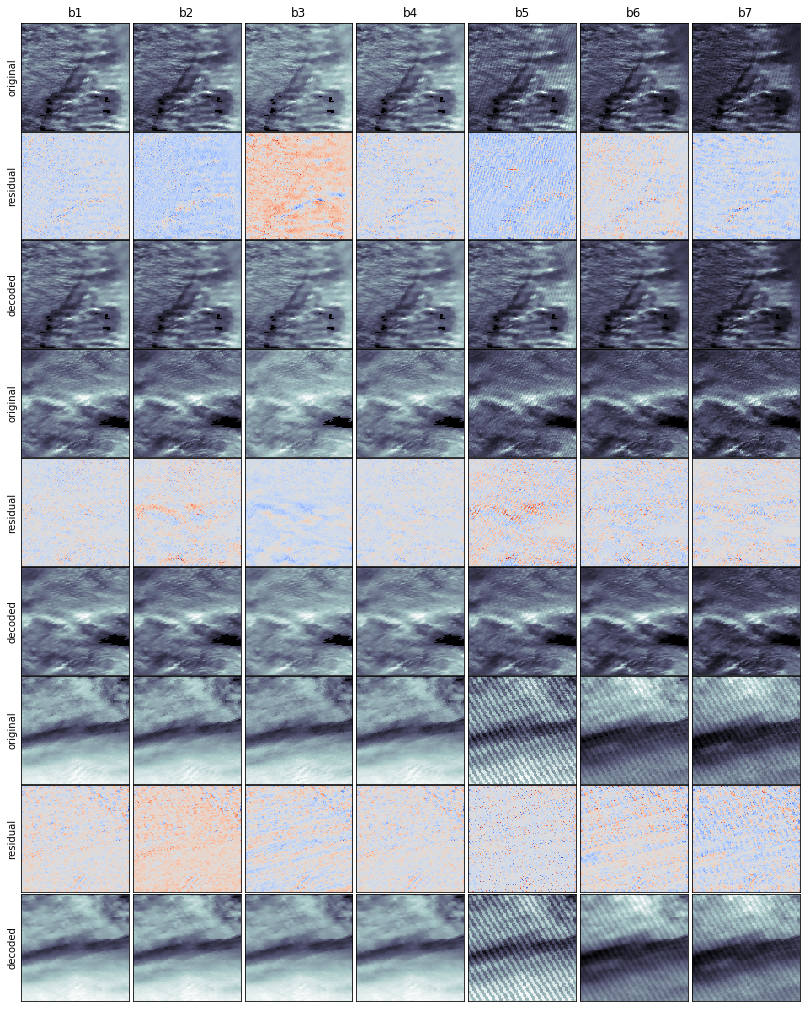

In [38]:
data.plot_residuals(n_samples=3, width=2);

# Bottleneck Activation Pattern
Recall the bottleneck representation of a patch is a `(height, width, depth)` shaped tensor where `height` and `width` are much smaller than the dimensions of the input patch and the `depth` of the bottleneck is large. The following heatmaps are the standard deviation in each pixel of the 3d bottleneck tensor. Each heatmap represents one activation channel in the depth dimension.

A linear combinatinon of these channels will be able to identify the edges of images where there is little information because we pad the convolutions. 

If an activation channel never varies then it probably is unused and the network could be smaller.

channels with a lower `depth` number seem less likely to collapse (have 0 stdev), probably because of residual connections.

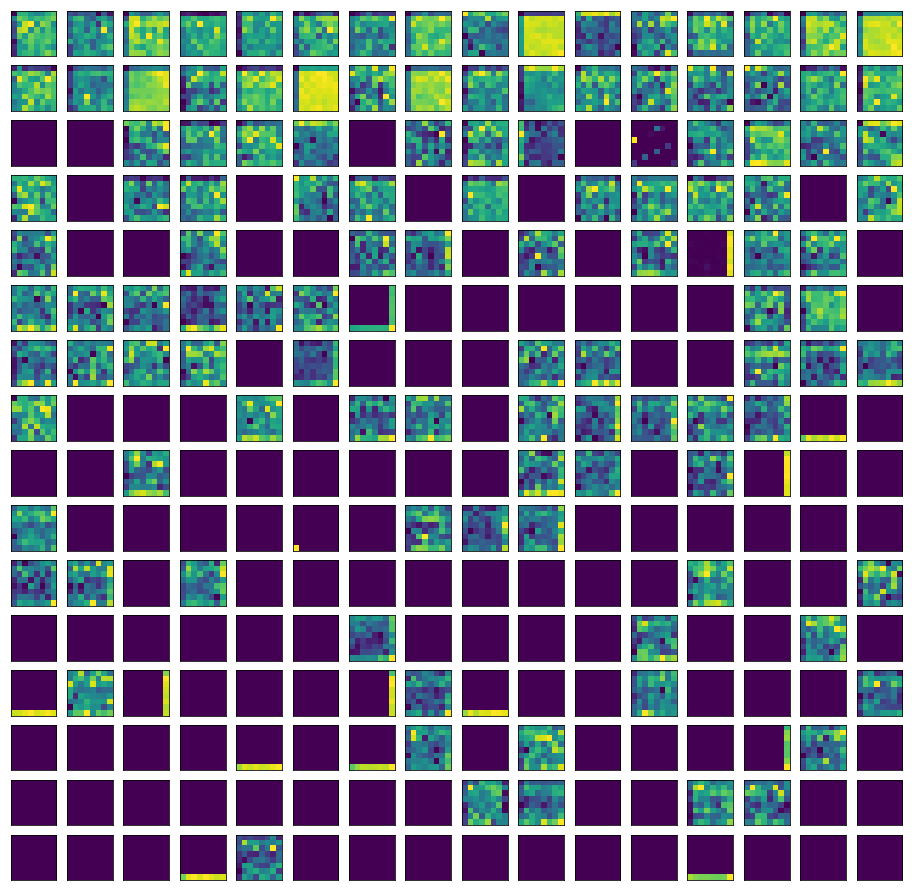

In [46]:
nrows=16
ncols=16
assert nrows * ncols

%matplotlib inline
fig, ax = plt.subplots(nrows, ncols, figsize=(nrows, ncols))

for i in range(16):
    for j in range(16):
        a = ax[i,j]
        a.imshow(data.raw_encs[:, :, :, i * ncols + j].std(axis=0))
        a.set_xticks([])
        a.set_yticks([])

# Activation Correlations
We examine the correlation matrix of the activations after taking the mean of the activations over the `height` and `width` dimensions. We also throw away nan-values caused by channel collapse. Presumably these channels should not be too correlated if they represent different information.

/anaconda3/envs/clouds/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/envs/clouds/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


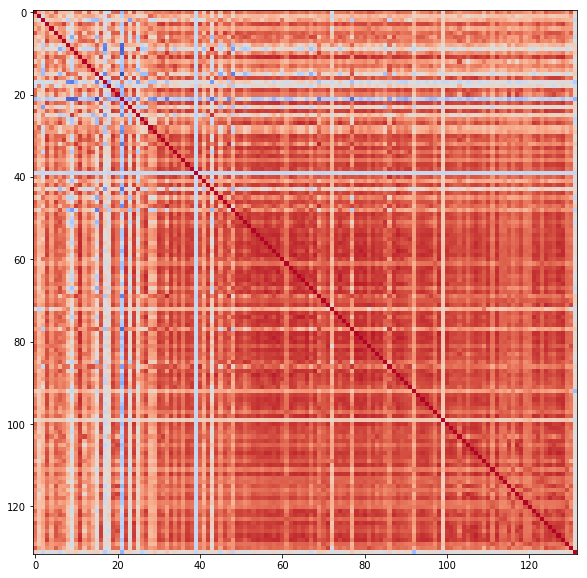

In [80]:
corr = np.corrcoef(data.encs.T)
corr_no_nan = corr[~np.isnan(corr).all(axis=0)][:, ~np.isnan(corr).all(axis=1)]
plt.figure(figsize=(10,10))
plt.imshow(corr_no_nan, cmap="coolwarm")

In [84]:
data.compute_pca()

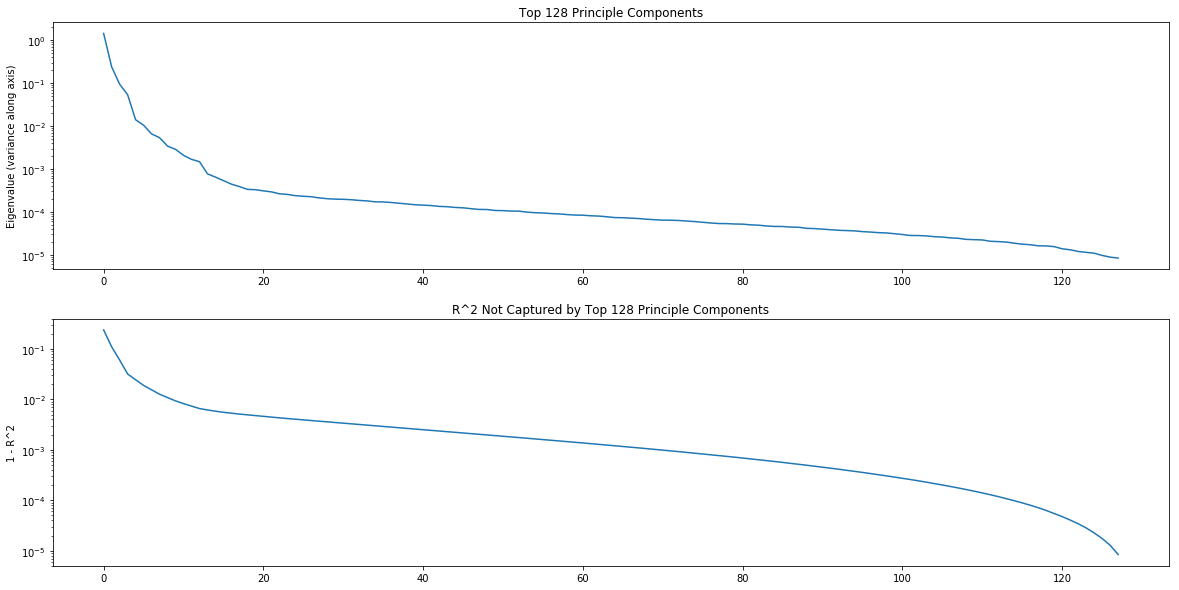

In [87]:
%matplotlib inline
D = 128
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10))

ax1.plot(data._evals[:D])
ax1.set_title("Top %d Principle Components"% D)
ax1.set_yscale("log")
ax1.set_ylabel("Eigenvalue (variance along axis)")

ax2.plot(1 - data._evals.cumsum()[:D] / data._evals.sum())
ax2.set_title("R^2 Not Captured by Top %d Principle Components"%D)
ax2.set_yscale("log")
ax2.set_ylabel("1 - R^2");